In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import re
import random
from scipy.stats import pearsonr

In [2]:
FACE_MESH = pd.read_csv('mediaPipe/faceMesh/face_mesh.csv')

In [7]:
def landmarks_mapper(video: str):
    
    OPENFACE_DIR = 'openFace/processed/'
    MEDIAPIPE_DIR = 'mediaPipe/processed/'
    OPENFACE_LANDMARKS = [i for i in range(0, 68)]
    
    of_df = pd.read_csv(OPENFACE_DIR + video + '_openface.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '_mediapipe.csv')
    
    final_df = of_df['frame']
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']]
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}']
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

In [4]:
def pearson(df: pd.DataFrame):
    
    pearson_lndmk = []
    for i in range(68):
        
        pearson_X = pearsonr(df[f'openface_x_{i}'].tolist(), df[f'mediapipe_x_{i}'].tolist())[0]
        pearson_Y = pearsonr(df[f'openface_y_{i}'].tolist(), df[f'mediapipe_y_{i}'].tolist())[0]
        pearson_lndmk.append((pearson_X+pearson_Y)/2)
    
    pearson_video = np.mean(pearson_lndmk)
    
    return pearson_video

In [16]:
videos = []
pearson_videos = []
for video in os.listdir('dataset/ElderReact_Data/ElderReact_train/'):
    
    video = video[:-4]
    
    videos.append(video)
    
    df = landmarks_mapper(video)
    pearson_videos.append(pearson(landmarks_mapper(video)))

pearson_dataset = pd.DataFrame({'video': videos, 'pearson': pearson_videos})
%store pearson_dataset
pearson_dataset

,video,pearson
0,whack_your_boss_12,0.974169
1,happy_wheels_54,0.968697
2,would_you_rather_29,0.983525
3,play_red_dead_138,0.763068
4,Branda_schmitz_116,0.987913
...,...,...
610,bully_burger_54,0.980151
611,game_of_thrones_16,0.991651
612,qwop_38,0.978327
613,cuphead_58,0.985006


In [2]:
%store -r pearson_dataset

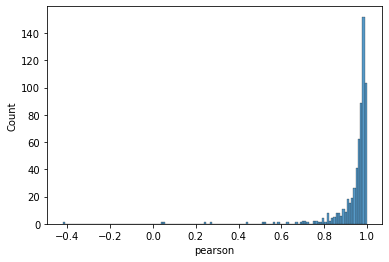

In [31]:
sns.histplot(data=pearson_dataset, x='pearson')
plt.show()

In [25]:
import altair as alt

base = alt.Chart(pearson_dataset)

bar = base.mark_bar().encode(
    x=alt.X('pearson', bin=alt.Bin(maxbins=615)),
    y='count()'
).properties(
    width=600,
    height=100
)

bar

alt.Chart(...)